# Importar bibliotecas e dados / Criar classe

https://www.kaggle.com/code/pranjalpandey12/simple-to-multiple-and-polynomial-regression-in-r
https://notebook.community/datascienceguide/datascienceguide.github.io/tutorials/multiple_regression_in_python
https://www.kaggle.com/code/carlmcbrideellis/variance-inflation-factor-vif-and-explainability

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats

from math import factorial
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [54]:
df_physics = pd.read_csv("dados_temperatura_pressao.csv")
df_generic = pd.read_csv("dados_genericos.csv")
df_mobility = pd.read_csv("dados_comunidades_mobilidade.csv")

In [55]:
def plot_corr(data, variables):
    if(variables): 
        data = data[variables]
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle("Distribuição das variáveis")
       
    corr_pearson = data.corr(method='pearson')
    corr_spearman = data.corr(method='spearman')
    
    mask = np.triu(np.ones_like(corr_pearson, dtype=bool))  # Create a mask for upper triangle
    
    ax = axs[0]
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", ax=ax, mask=mask)
    ax.set_title("Matriz de Correlação de Pearson")
    
    ax = axs[1]
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", ax=ax, mask=mask)
    ax.set_title("Matriz de Correlação de Spearman")
    
    plt.tight_layout()
    plt.show()
    
def plot_res(Y_hat, Residuals, X, Results, label = ''):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(Y_hat, Residuals, alpha=0.8)
    
    plt.axhline(y=0, color='r', linestyle='--')

    title = 'Resíduos - '  + label

    plt.title(title)
    plt.xlabel('Ŷ (Resposta ajustada)')
    plt.ylabel('Resíduos')
    
    plt.subplot(1, 2, 2)
    
    for i in range(X.shape[1]):
        plt.scatter(X.iloc[:, i] , Residuals, label=f'X{i+1} = {X.columns[i]}', alpha=0.8)
    
    plt.axhline(y=0, color='r', linestyle='--')
    title = r"$\hat{Y} = "
    for i, var in enumerate(Results):
        if i:
            title = title + f"{var : .3f}" + r"*X" + f"{i}"
            if(i < len(Results) - 1):
                 title = title + " +"
        else: title = title + f"{var : .3f} +"
    
    plt.title(title + "$")
    plt.xlabel('Valor da variável preditora')
    plt.ylabel('Resíduos')
    plt.legend(bbox_to_anchor = (1,1))
    
    plt.tight_layout()
    plt.show()
    
def plot_scatter(df, features , categorize = False, categoric_feat = None, categories = None, plot_size=(4, 4)):
 
    def plot(df, title):
        g = sns.pairplot(df[features], diag_kind='kde', height=plot_size[1], aspect=plot_size[0]/plot_size[1])
        g.map_upper(sns.kdeplot, fill=True, thresh=0, levels=100, cmap="mako")
        g.map_lower(sns.regplot, color=".3", line_kws=dict(color="r"))
        g.fig.suptitle(title, y=1.02)
    
    if categories:
        if (categories == 'all') and (categorize):
            categories = df[categoric_feat].sort_values().unique()
        for categ in categories:
            plot(df[df[categoric_feat] == categ], title=f"Análise features - {categoric_feat.title()} {categ}")
            plt.show() 
    else:
        plot(df, title="Análise features")
        plt.show()
        
def questao_2(df, model_linear, model_quadratic):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 
    x_plot = np.linspace(0, df['Temperatura'].max()+5, 100)
    
    ax = axs[0]
    params_linear = model_linear.params
    y_hat = params_linear.iloc[0] + x_plot*params_linear.iloc[1]
    
    ax.plot(x_plot,y_hat,'-',color='red',linewidth=1.4,label=f'Y = {params_linear.iloc[0]:.4f} + {params_linear.iloc[1]:.4f}X')
    ax.plot(df['Temperatura'], df['Pressao'], 'o' ,mfc='white', mec='black')
    
    ax.set_xlabel(r'Temperatura')
    ax.set_ylabel(r'Pressao')
    ax.legend(loc = 'upper left', fontsize = 10)
    ax.set_title("Regressão Linear", fontsize = 14)
    ax.set_xlim([0,df['Temperatura'].max()+5])
    ax.set_ylim([-30,200])
    
    ax = axs[1]
    params_poly2 = model_quadratic.params
    y_hat_2 = params_poly2.iloc[0] + x_plot * params_poly2.iloc[1] + (x_plot ** 2) * params_poly2.iloc[2]
    
    ax.plot(x_plot, y_hat_2, '-', color = 'blue', linewidth = 1.4,
            label = f'Y = {params_poly2.iloc[0]:.4f} + {params_poly2.iloc[1]:.4f}X + {params_poly2.iloc[2]:.4f}X^2')
    ax.plot(df['Temperatura'], df['Pressao'], 'o' ,mfc='white', mec='black')
    
    ax.set_xlabel(r'Temperatura')
    ax.set_ylabel(r'Pressao')
    ax.legend(loc = 'upper left', fontsize = 10)
    ax.set_title("Regressão 2º grau", fontsize = 14)
    ax.set_xlim([0,df['Temperatura'].max()+5])
    ax.set_ylim([-30,200]);
    
    plt.show()
    def stats_ms(modelo, label):
        print(f"Estatísticas Resumidas - {label}:\nMS - Regressão:\t\t{modelo.mse_model:6.3f}\nMS - Resíduos:\t\t{modelo.mse_resid:8.3f}\nR²:\t\t\t\t\t{modelo.rsquared:8.3f}\n")
        
    stats_ms(model_linear, 'Modelo linear')
    stats_ms(model_quadratic, 'Modelo 2º grau')
    
def questao_4(df_mobility, params_mobility_linear, params_mobility_quadratic, params_mobility_polynomial, plot_domain = False):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5)) 
    x_sup = df_mobility['Commute'].max()+.1
    x_inf = 0
    if (plot_domain):
        x_inf = -20
        x_sup = 20
        
    x_plot = np.linspace(x_inf, x_sup, 100)
    
    ax = axs[0]
    y_hat = params_mobility_linear.iloc[0] + x_plot*params_mobility_linear.iloc[1]

    ax.plot(df_mobility['Commute'],df_mobility['Mobility'], 'o',markerfacecolor='white')
    ax.plot(x_plot,y_hat,'-',color='red',linewidth=3,label=f'Y = {params_mobility_linear.iloc[0]:.4f} + {params_mobility_linear.iloc[1]:.4f}X')
    
    ax.set_xlabel('Commute')
    ax.set_ylabel('Mobility')
    ax.legend(loc='upper left',fontsize=10)
    ax.set_title("Regressão Linear", fontsize = 14)
    ax.set_xlim([x_inf,x_sup])
    ax.set_ylim([0,.6])
    if plot_domain:
        ax.set_xlim([-15,15])
        ax.set_ylim([-5,20])
    
    
    ax = axs[1]
    y_hat = params_mobility_quadratic.iloc[0] + (x_plot**2)*params_mobility_quadratic.iloc[1]

    ax.plot(df_mobility['Commute'],df_mobility['Mobility'], 'o',markerfacecolor='white')
    ax.plot(x_plot,y_hat,'-',color='red',linewidth=3,label=f'Y = {params_mobility_quadratic.iloc[0]:.4f} + {params_mobility_quadratic.iloc[1]:.4f}X^2')
    
    ax.set_xlabel('Commute')
    ax.set_ylabel('Mobility')
    ax.legend(loc='upper left',fontsize=10)
    ax.set_title("Regressão Quadrática", fontsize = 14)
    ax.set_xlim([x_inf,x_sup])
    ax.set_ylim([0,.6])
    if plot_domain:
        ax.set_xlim([-15,15])
        ax.set_ylim([-5,20])
    
    
    ax = axs[2]
    y_hat = params_mobility_polynomial.iloc[0] + x_plot*params_mobility_polynomial.iloc[1] + (x_plot**2)*params_mobility_polynomial.iloc[2]
    
    ax.plot(df_mobility['Commute'],df_mobility['Mobility'], 'o',markerfacecolor='white')
    ax.plot(x_plot,y_hat,'-',color='red',linewidth=3,label=f'Y = {params_mobility_polynomial.iloc[0]:.4f} + {params_mobility_polynomial.iloc[1]:.4f}X + {params_mobility_polynomial.iloc[2]:.4f}X^2')
    
    ax.set_xlabel('Commute')
    ax.set_ylabel('Mobility')
    ax.legend(loc='upper left',fontsize=10)
    ax.set_title("Regressão Polinomial", fontsize = 14)
    ax.set_xlim([x_inf,x_sup])
    ax.set_ylim([0,.6]);
    
    if plot_domain:
        ax.set_xlim([-15,15])
        ax.set_ylim([-5,20]);
    
    
    plt.show()
    def stats_ms(modelo, label):
        print(f"Estatísticas Resumidas - {label}:\nMS - Regressão:\t\t{modelo.mse_model:7.3f}\nMS - Resíduos:\t\t{modelo.mse_resid:8.3f}\nR²:\t\t\t\t\t{modelo.rsquared:8.3f}\n")
    
    if not plot_domain:    
        stats_ms(model_mobility_linear, 'Modelo linear')
        stats_ms(model_mobility_quadratic, 'Modelo Quadratico')
        stats_ms(model_mobility_polynomial, 'Modelo Polinomial')
            
def questao_4Z(df_mobility_clean, model_mobility_polynomial_Z):
    params_mobility_polynomial_Z = model_mobility_polynomial_Z.params
    x_inf = df_mobility_clean['Z'].min()-.2
    x_sup = df_mobility_clean['Z'].max()+.2
    x_plot = np.linspace(x_inf, x_sup)
    y_hat = params_mobility_polynomial_Z.iloc[0] + x_plot*params_mobility_polynomial_Z.iloc[1] + (x_plot**2)*params_mobility_polynomial_Z.iloc[2]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
    
    ax.plot(df_mobility_clean['Z'],df_mobility_clean['Mobility'], 'o', mec = 'black', mfc = 'white')
    ax.plot(x_plot,y_hat,'-',color='blue',linewidth=3, 
            label=f'Y = {params_mobility_polynomial_Z.iloc[0]:.4f} + {params_mobility_polynomial_Z.iloc[1]:.4f}Z + {params_mobility_polynomial_Z.iloc[2]:.4f}Z^2')
    
    
    ax.set_xlabel('Z')
    ax.set_ylabel('Mobility')
    ax.legend(loc='upper left',fontsize=10)
    ax.set_title("Regressão Polinomial Centralizada", fontsize = 14)
    ax.set_xlim([x_inf, x_sup])
    ax.set_ylim([0,.6])
    
        
    plt.show()
    
    def stats_ms(modelo, label):
        print(f"Estatísticas Resumidas - {label}:\nMS - Regressão:\t\t{modelo.mse_model:7.3f}\nMS - Resíduos:\t\t{modelo.mse_resid:8.3f}\nR²:\t\t\t\t\t{modelo.rsquared:8.3f}\n")
    
    stats_ms(model_mobility_polynomial_Z, 'Modelo Polinomial - Normalizado')

def questao_4region(df_mobility, model_mobility_polynomial):
    
    params_region = model_mobility_polynomial_region.params
    def north_reg(x, params):
        return params.iloc[0] + x*params.iloc[2] + (x**2)*params.iloc[4]
    
    def south_reg(x, params):
        return (params.iloc[0] + params.iloc[1]) + x*(params.iloc[2] + params.iloc[3]) + (x**2)*(params.iloc[4] + params.iloc[5])
    
    df_mobility['pred'] = df_mobility.apply(lambda row: south_reg(row['Commute'], params_region) if row['Region'] == 1 else north_reg(row['Commute'], params_region), axis=1)
    
    x_plot = np.linspace(0, df_mobility['Commute'].max()+1, 100)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 8)) 
    
    ax = axs[0]
    df_sul = df_mobility[df_mobility['Region'] == 0]
    ax.plot(df_sul['Commute'],df_sul['Mobility'], 'o',mfc='white', mec='black')
    ax.plot(x_plot,south_reg(x_plot, params_region),'-',color='red',linewidth=3,label='Estados do Sul')
    
    ax.set_xlabel('Commute')
    ax.set_ylabel('Mobility')
    ax.set_title("Regressão Polinomial Categorizada", fontsize = 14)
    ax.legend(loc='upper left',fontsize=10)
    ax.set_xlim([0,1])
    ax.set_ylim([0,.5])
    
    ax = axs[1]
    df_norte = df_mobility[df_mobility['Region'] == 1]
    ax.plot(df_norte['Commute'],df_norte['Mobility'], 'o',mfc='white', mec='black')
    ax.plot(x_plot,north_reg(x_plot, params_region),'-',color='blue',linewidth=3,label='Estados do Norte')
    
    ax.set_xlabel('Commute')
    ax.set_ylabel('Mobility')
    ax.set_title("Regressão Polinomial Categorizada", fontsize = 14)
    ax.legend(loc='upper left',fontsize=10)
    ax.set_xlim([0,1])
    ax.set_ylim([0,.5])
    
    plt.show()    


In [56]:
def define_model(df, target, features, poly_grade = 1, categ_variable = False, category = None ):
    X_raw = np.array(df[features])
    if(len(features) == 1): X_raw = X_raw.reshape(-1,1)
    
    dict_model = {}
    for i, feat in enumerate(features):
        dict_model[i] = (f'x{i}', feat)
        
    poly = PolynomialFeatures(poly_grade)
    
    X_poly = poly.fit_transform(X_raw)
    new_features = poly.get_feature_names_out()
    
    def replace_func(x):
        n_var = len(dict_model)
        for rep in range(n_var):
            index = n_var - rep - 1
            x = x.replace(dict_model[index][0], dict_model[index][1])
        return x
    
    mapped_array = np.array([replace_func(x) for x in new_features])
    dict_features = {i: mapped_array[i] for i in range(len(mapped_array))}
    
    X = pd.DataFrame(X_poly)
    X.rename(columns=dict_features, inplace=True)
    model = sm.OLS(df[target], X).fit() 
    return X, model

# Exercício 2)

## Análise exploratória

C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


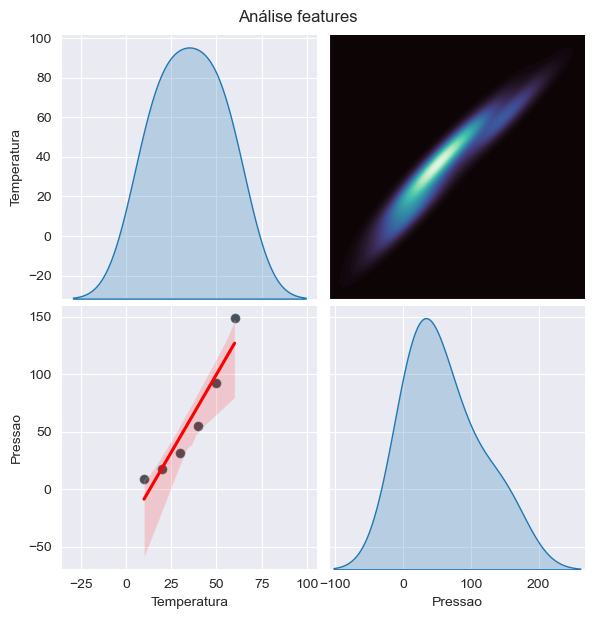

In [57]:
plot_scatter(df = df_physics, features = ['Temperatura', 'Pressao'] ,  plot_size=(3,3))

***
## Regressão e Resíduos

É possível observar nos plots abaixo que o modelo de regressão de 2º grau se adequa muito melhor que o modelo linear, sendo evidente o melhor ajuste do modelo de 2º grau.

Além disso, observa-se que os erros são bem menores no caso de grau 2 quando comparado com o modelo linear, também sugerindo a melhor adequação do modelo de 2º grau.

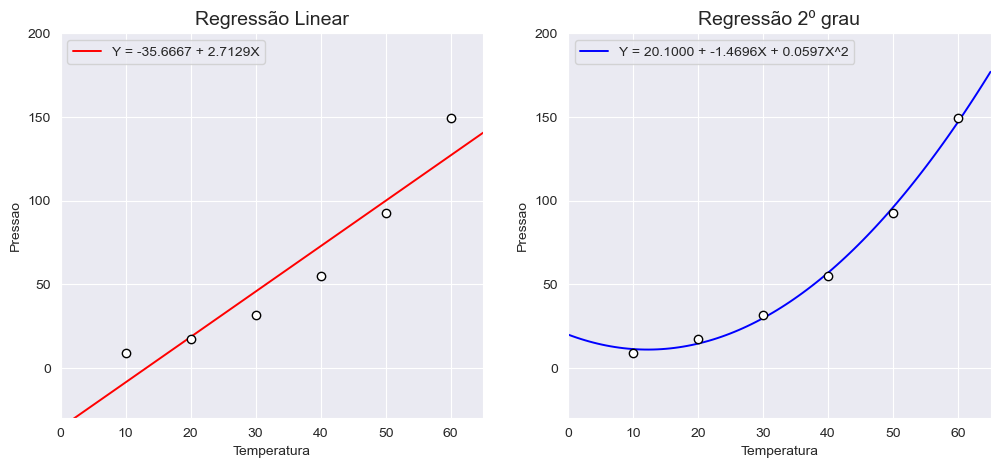

Estatísticas Resumidas - Modelo linear:
MS - Regressão:		12879.289
MS - Resíduos:		 342.615
R²:					   0.904

Estatísticas Resumidas - Modelo 2º grau:
MS - Regressão:		7106.056
MS - Resíduos:		  12.545
R²:					   0.997


In [58]:
X_physics_linear, model_physics_linear = define_model(df = df_physics, target = 'Pressao', features = ['Temperatura'], poly_grade = 1)

# model_physics = smf.ols(formula='Pressao ~ Temperatura + I(Temperatura**2)', data=df_physics).fit()
X_physics, model_physics = define_model(df = df_physics, target = 'Pressao', features = ['Temperatura'], poly_grade = 2)

questao_2(df = df_physics, model_linear = model_physics_linear, model_quadratic = model_physics)

In [59]:
print(model_physics.summary(slim = True))

                            OLS Regression Results                            
Dep. Variable:                Pressao   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
No. Observations:                   6   F-statistic:                     566.4
Covariance Type:            nonrobust   Prob (F-statistic):           0.000136
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
1                20.1000      6.336      3.172      0.050      -0.064      40.264
Temperatura      -1.4696      0.415     -3.545      0.038      -2.789      -0.150
Temperatura^2     0.0597      0.006     10.307      0.002       0.041       0.078

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.55e+03. This might indicate that there are
strong multicol

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Na tabela ANOVA acima, para o caso de regressão de 2º grau, observa-se que o teste t par ao termo quadrático tem p-valor de 0.002, portanto rejeita-se a Hipótese nula de que o termo quadrático é igual a zero, tendo o termo linear e com o intercepto no modelo, de forma estatísticamente significante.

Observando os resíduos, fica claro que no caso da regressão linear os resíduo apresentam um padrão (parábola) que sugere que um modelo de grau mais elevado seria mais adequado. Plotando os resíduos para a regressão de 2º grau, observa-se um padrão quase aleatório em torno de 0, evidenciando melhor ajuste desse modelo.

Portanto, analisando a curva gerada, o teste t para o termo quadrático e a plotagem de resíduos, conclui-se que o modelo de regressão de 2º grau é o mais adequado para o caso.

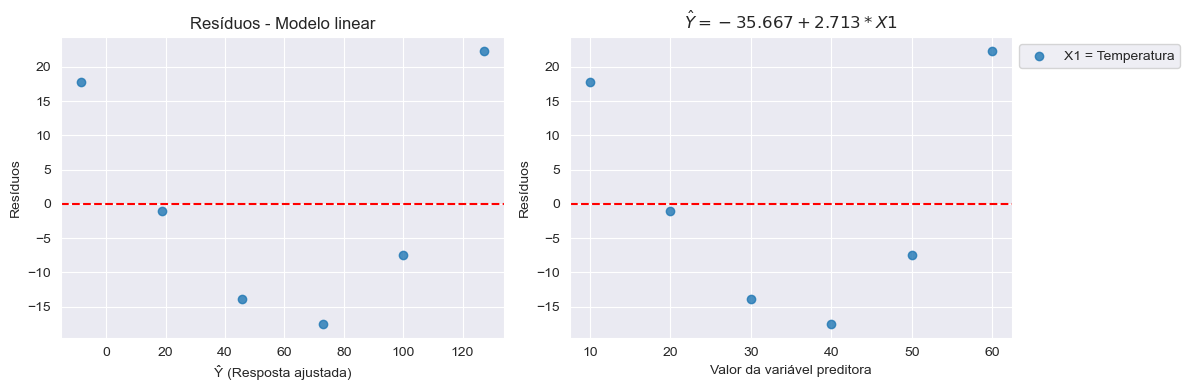

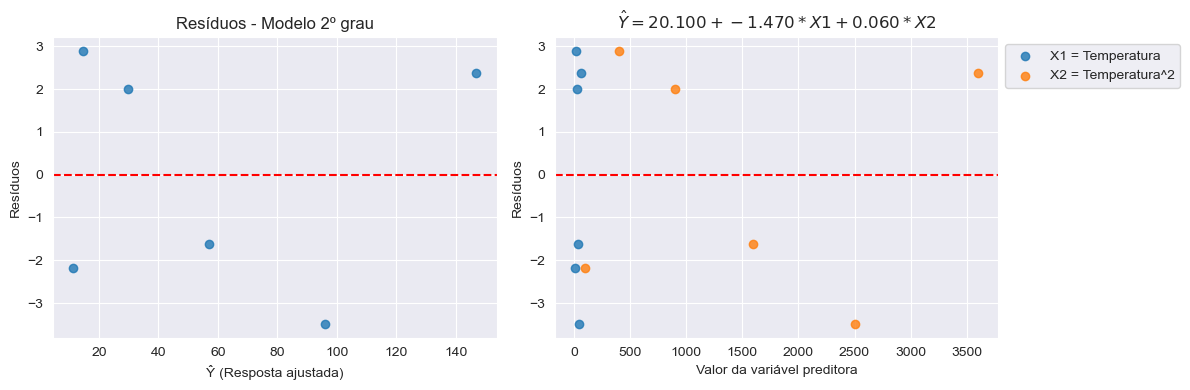

In [60]:
plot_res(Y_hat = model_physics_linear.predict(),Residuals =  model_physics_linear.resid, X = X_physics_linear.iloc[:, 1:],
         Results = model_physics_linear.params, label = "Modelo linear")

plot_res(Y_hat = model_physics.predict(), Residuals =  model_physics.resid,X = X_physics.iloc[:, 1:],
         Results = model_physics.params, label = "Modelo 2º grau")

***
***
***
# Exercício 3)

## a) e b) Ajuste do modelo e Estatística t

Aparentemente, considerando o teste t como critério, todas a covariáveis, dado a existencia das demais no modelo, poderiam ser descartadas. Porém, essa abordagem permite descartar somente uma variável, sendo necessário um teste F para decidir quais variáveis podem ser descartadas no modelo conjuntamente - observando o fato que muitas das covariáveis tem alta correlação, destacada no plot abaixo.

In [61]:
# model_generic = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x1**2) + I(x2**2) + I(x3**2)', data=df_generic).fit()
X_generic, model_generic = define_model(df = df_generic, target = 'Y', features = ['x1', 'x2', 'x3'], poly_grade = 2)
print(model_generic.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     19.63
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           5.05e-07
Time:                        22:51:55   Log-Likelihood:                 42.171
No. Observations:                  26   AIC:                            -64.34
Df Residuals:                      16   BIC:                            -51.76
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1             -1.7694      1.287     -1.375      0.1

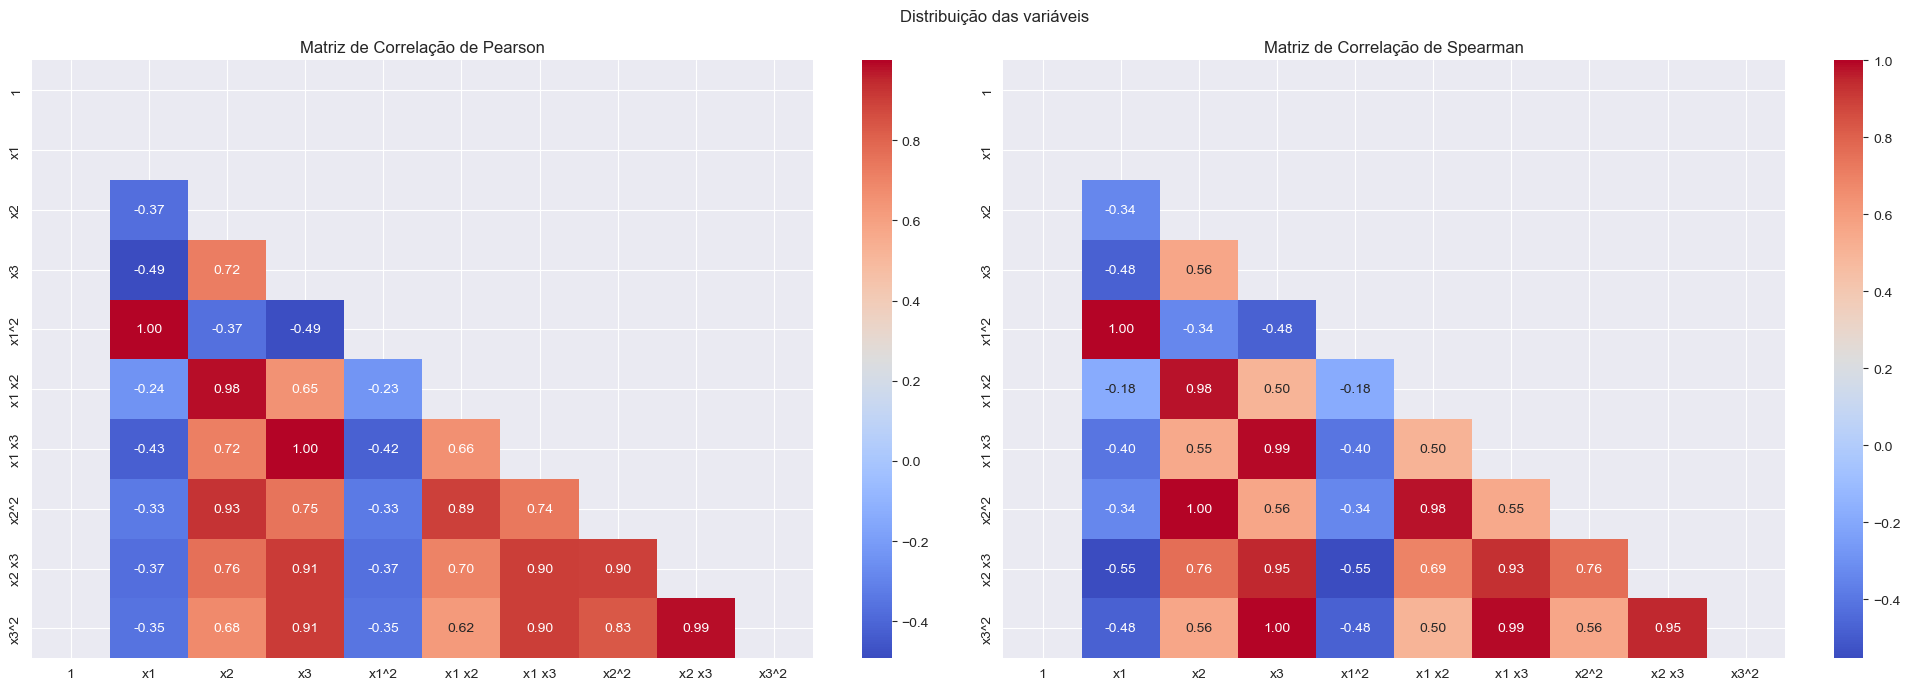

In [62]:
plot_corr(X_generic, variables = None)

## c) Análise dos Resíduos

Observando os resíduos, para cada uma das variáveis, não se detecta nenhum padrão que sugira a não normalidade da distribuição dos resíduos (apesar do teste com a estatítica JB na tabela ANOVA acima rejeitar a normalidade dos resíduos com 5% de significância).

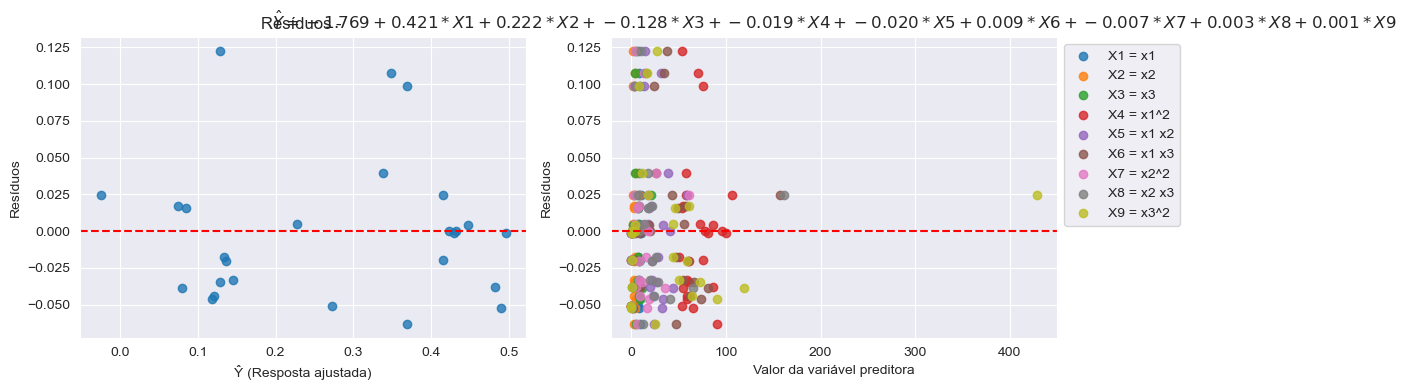

In [63]:
plot_res(Y_hat = model_generic.predict(), Residuals =  model_generic.resid, X = X_generic.iloc[:, 1:], Results = model_generic.params)

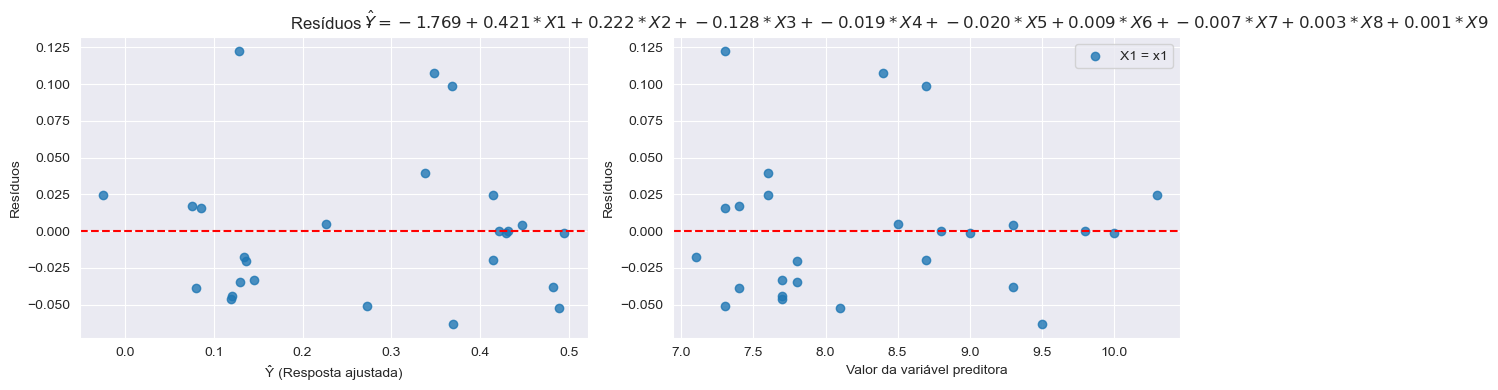

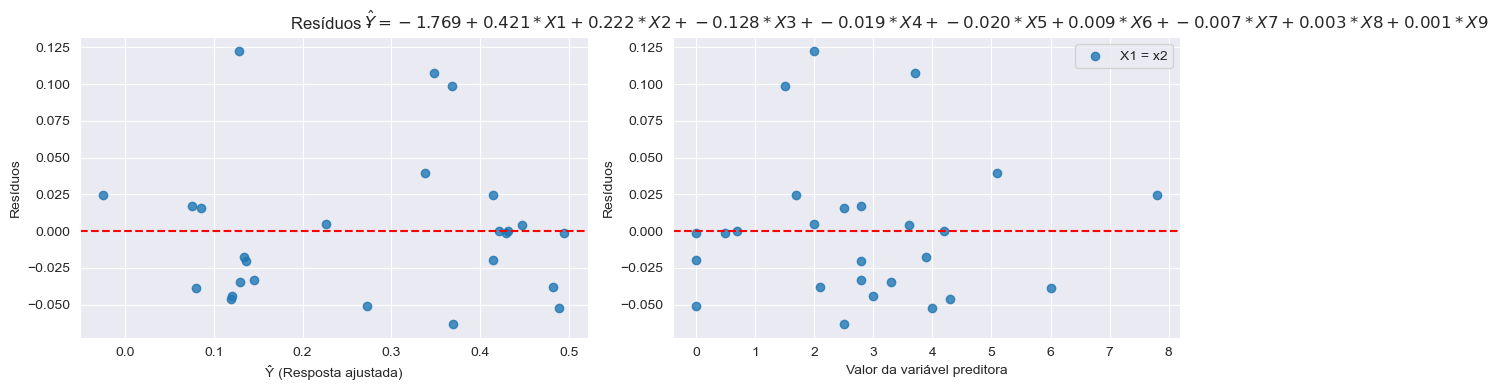

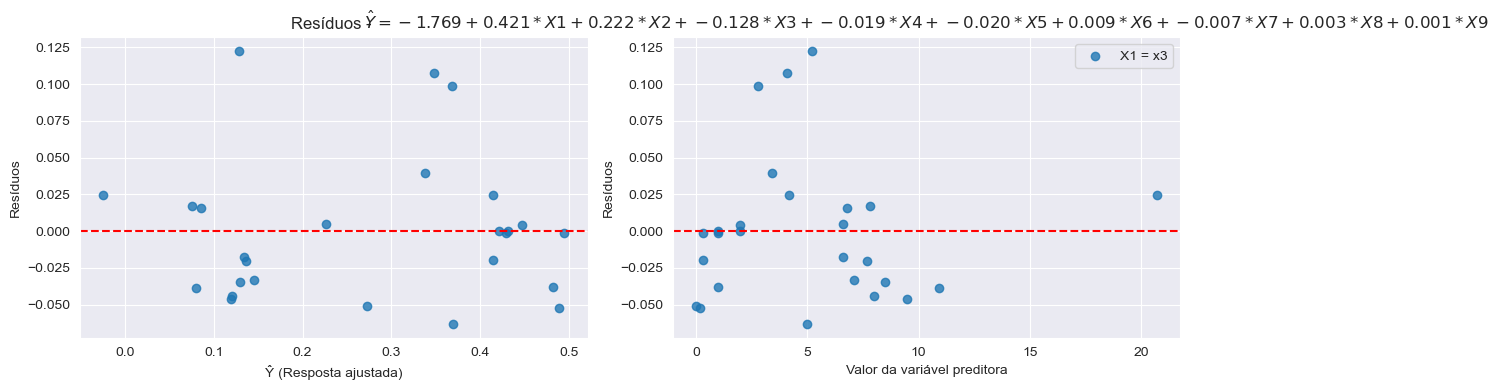

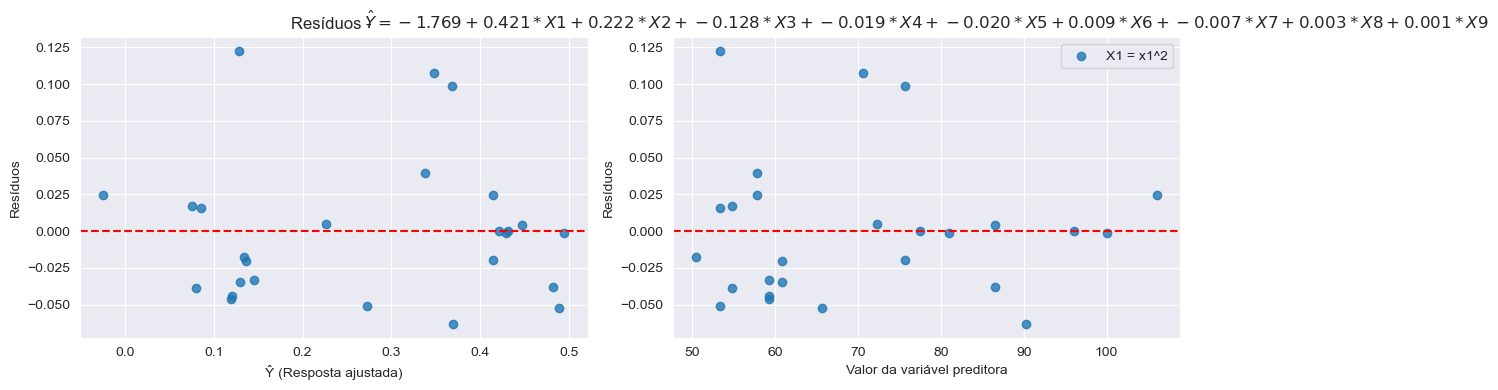

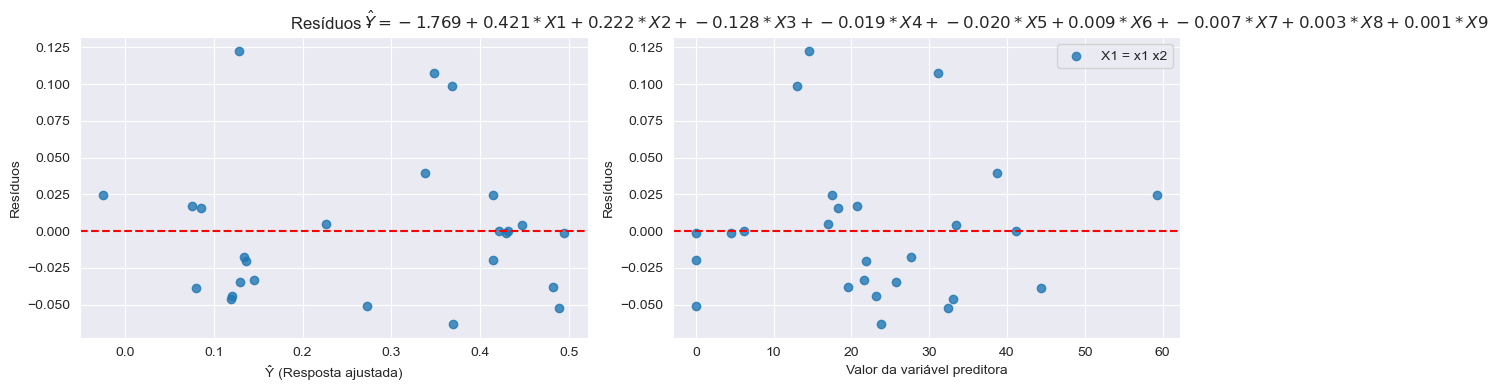

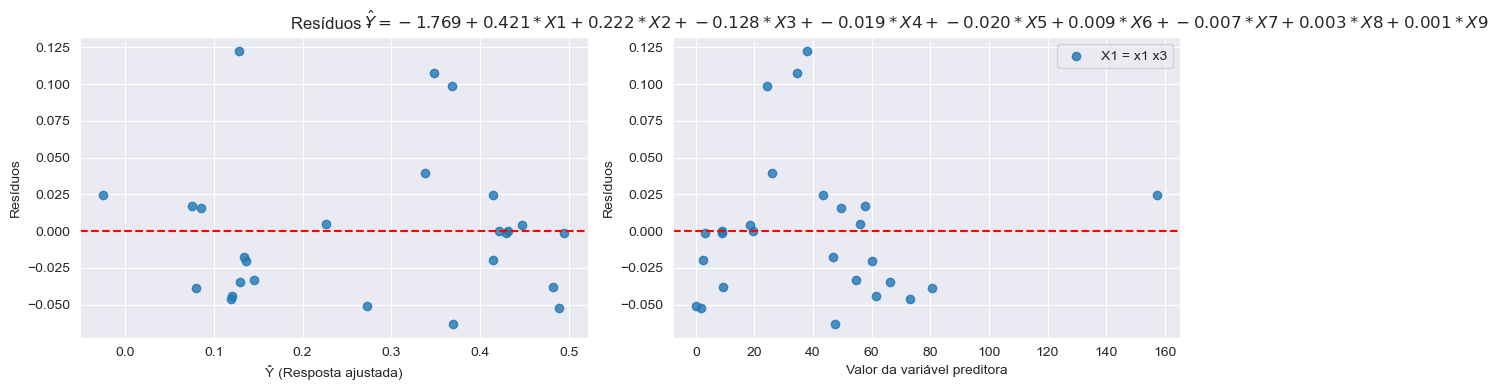

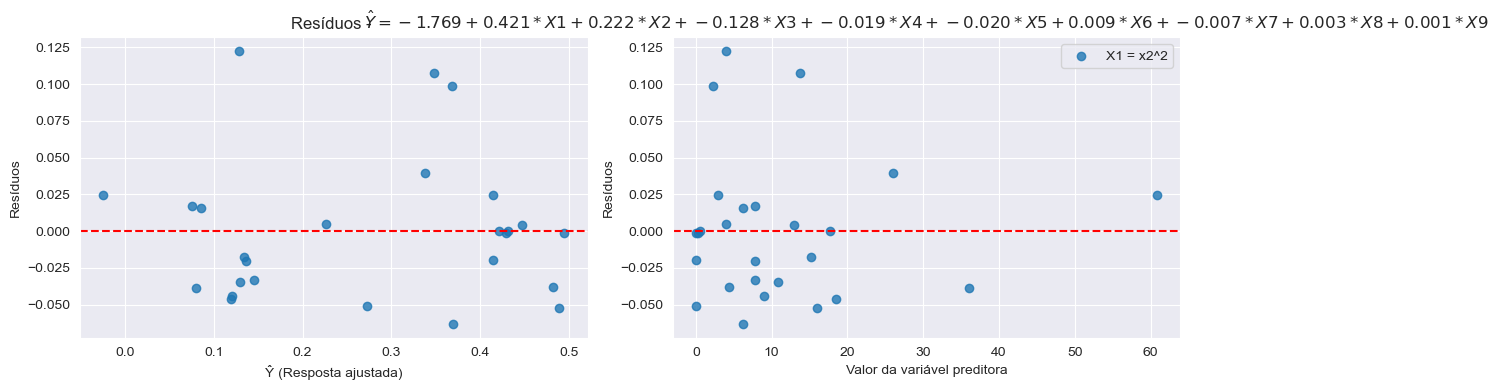

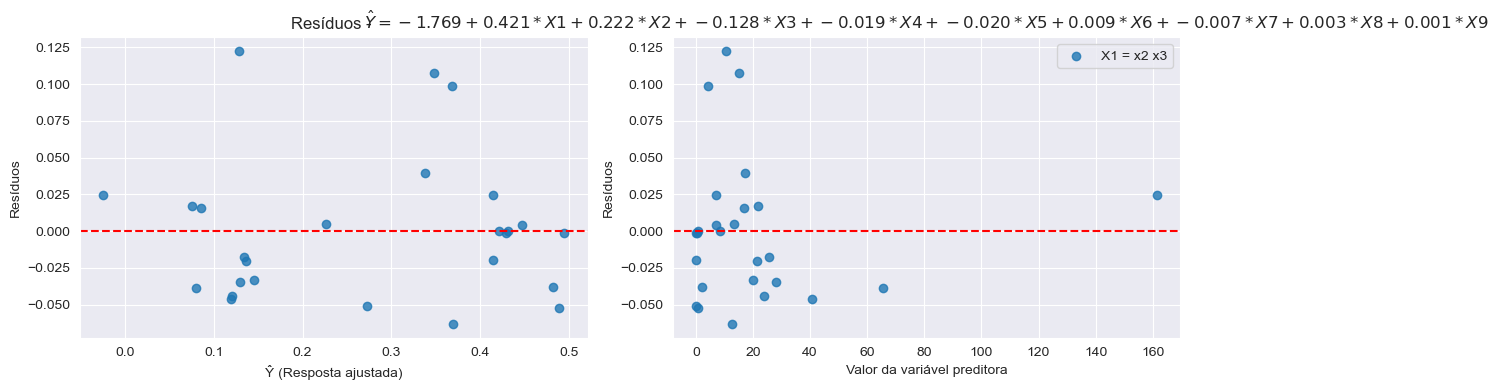

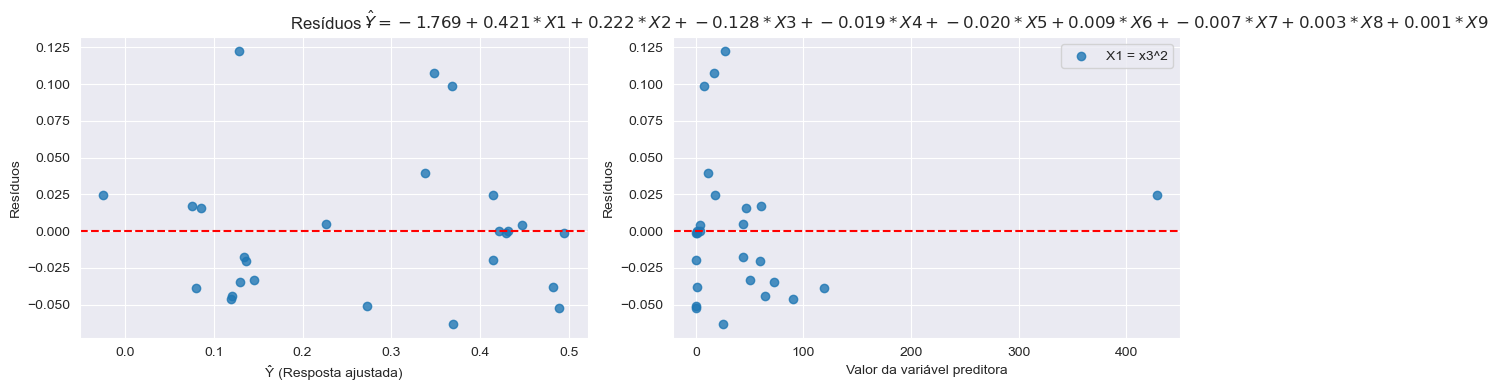

In [64]:
for i in range(9):
    plot_res(Y_hat = model_generic.predict(), Residuals =  model_generic.resid, X = X_generic.iloc[:, 1+i:2+i], Results = model_generic.params)

## d) Extra sum of squares

Dada a alta correlação observada, prossegue-se realizando um Teste F para cada uma dos termos de segunda ordem do modelo. É evidente que eles pouco contribuem, quando das outras covariáveis no modelo. Desta forma, opta-se por retirar X1^2 e prosseguir com outro teste F.

In [65]:
model_reduced_1 = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x2**2) + I(x3**2)', data=df_generic).fit()
model_reduced_2 = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x1**2) + I(x3**2)', data=df_generic).fit()
model_reduced_3 = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x1**2) + I(x2**2)', data=df_generic).fit()


MSE = model_generic.ssr / model_generic.df_resid # SSE / (N - P)
sse_1 = model_reduced_1.ssr #SSE modelo reduzido
sse_2 = model_reduced_2.ssr #SSE modelo reduzido
sse_3 = model_reduced_3.ssr #SSE modelo reduzido

ess_r_1 = sse_1 - model_generic.ssr
ess_r_2 = sse_2 - model_generic.ssr
ess_r_3 = sse_3 - model_generic.ssr

f_1 = ess_r_1 / MSE
f_2 = ess_r_2 / MSE
f_3 = ess_r_3 / MSE

p_value1 = stats.f.sf(f_1, 1, model_generic.df_resid)
p_value2 = stats.f.sf(f_2, 1, model_generic.df_resid)
p_value3 = stats.f.sf(f_3, 1, model_generic.df_resid)

print(f"P-valor do teste F para variável X1^2:\t{p_value1:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")
print(f"P-valor do teste F para variável X2^2:\t{p_value2:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")
print(f"P-valor do teste F para variável X3^2:\t{p_value3:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")

P-valor do teste F para variável X1^2:	0.267 	-->	Não rejeito hipótese nula: termo é igual a zero.
P-valor do teste F para variável X2^2:	0.545 	-->	Não rejeito hipótese nula: termo é igual a zero.
P-valor do teste F para variável X3^2:	0.575 	-->	Não rejeito hipótese nula: termo é igual a zero.


In [66]:
model_reduced = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x2**2) + I(x3**2)', data=df_generic).fit()
model_reduced_2 = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x3**2)', data=df_generic).fit()
model_reduced_3 = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x3**2)', data=df_generic).fit()

MSE = model_reduced.ssr / model_reduced.df_resid # SSE / (N - P)
sse_2 = model_reduced_2.ssr #SSE modelo reduzido
sse_3 = model_reduced_3.ssr #SSE modelo reduzido

ess_r_2 = sse_2 - model_reduced.ssr
ess_r_3 = sse_3 - model_reduced.ssr

f_2 = ess_r_2 / MSE
f_3 = ess_r_3 / MSE

p_value2 = stats.f.sf(f_2, 1, model_reduced.df_resid)
p_value3 = stats.f.sf(f_3, 1, model_reduced.df_resid)

print(f"P-valor do teste F para variável X2^2:\t{p_value2:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")
print(f"P-valor do teste F para variável X3^2:\t{p_value3:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")

P-valor do teste F para variável X2^2:	0.429 	-->	Não rejeito hipótese nula: termo é igual a zero.
P-valor do teste F para variável X3^2:	0.429 	-->	Não rejeito hipótese nula: termo é igual a zero.


In [67]:
model_reduced = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3 + I(x3**2)', data=df_generic).fit()
model_reduced_3 = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3', data=df_generic).fit()

MSE = model_reduced.ssr / model_reduced.df_resid # SSE / (N - P)
sse_3 = model_reduced_3.ssr

ess_r_3 = sse_3 - model_reduced.ssr

f_3 = ess_r_3 / MSE

p_value3 = stats.f.sf(f_3, 1, model_reduced.df_resid)

print(f"P-valor do teste F para variável X3^2:\t{p_value3:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")

P-valor do teste F para variável X3^2:	0.277 	-->	Não rejeito hipótese nula: termo é igual a zero.


In [68]:
model_reduced = smf.ols(formula='Y ~ x1*x2 + x1*x3 + x2*x3', data=df_generic).fit()
model_reduced_cruz = smf.ols(formula='Y ~ x1 + x2 + x3', data=df_generic).fit()

MSE = model_reduced.ssr / model_reduced.df_resid # SSE / (N - P)
sse_cruz = model_reduced_cruz.ssr

ess_r_cruz = sse_cruz - model_reduced.ssr

f_cruz = ess_r_cruz / (3 * MSE) # 3 termos cruzados a menos

p_value3 = stats.f.sf(f_cruz, 3, model_reduced.df_resid)

print(f"P-valor do teste F para termos cruzados:\t{p_value3:.3f} \t-->\tNão rejeito hipótese nula: termo é igual a zero.")

P-valor do teste F para termos cruzados:	0.132 	-->	Não rejeito hipótese nula: termo é igual a zero.


No teste mais acima observa-se a retirada dos termos quadráticos de X2 e X3, quando o modelo já está sem o termo quadrático X1. No teste mais abaixo, retira-se X3, quando os termos quadráticos de X1 e X2 já não estão no modelo.

Em ambos os casos conclui-se, através do teste F adequado, que os termos quadráticos pouco influenciam no modelo, bem como outro teste é feito para os termos cruzados - e também não rejeita a hipótese que os termos cruzados são iguais a zero conjuntamente, e desse modo o modelo mais indicado é:

Y = β0 + β1X1 + β2X2 + β3X3 + erro



***
***
***

# Exercício 4

## a)

Aparentemente o modelo quadrático teve melhor ajuste nos dados, e como critério o menor erro da regressão, opta-se por esse modelo (estatísticas AIC e BIC muito similares para todos os casos).

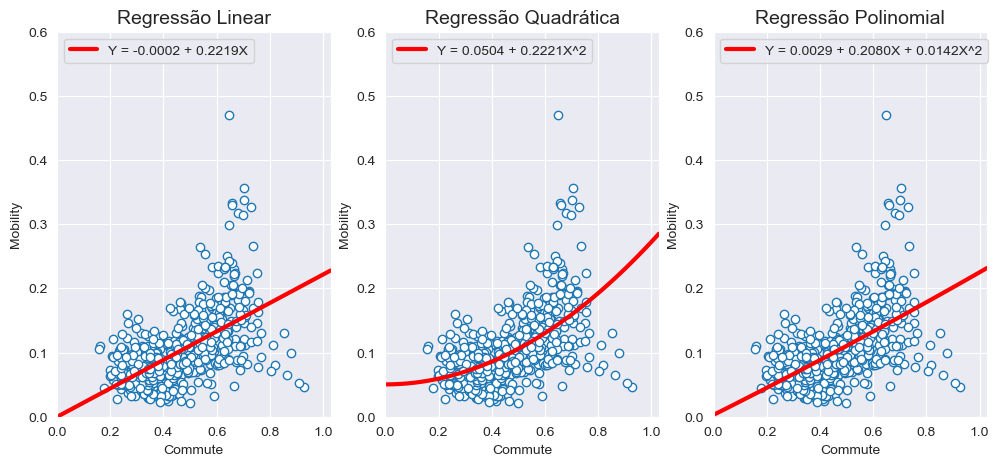

Estatísticas Resumidas - Modelo linear:
MS - Regressão:		  0.704
MS - Resíduos:		   0.002
R²:					   0.349

Estatísticas Resumidas - Modelo Quadratico:
MS - Regressão:		  0.687
MS - Resíduos:		   0.002
R²:					   0.340

Estatísticas Resumidas - Modelo Polinomial:
MS - Regressão:		  0.352
MS - Resíduos:		   0.002
R²:					   0.349


In [69]:
south_mask = ["VA", "FL", "GA","AR", "AL", "LA", "MS", "NC", "SC", "TN", "TX"]
df_mobility['Region'] = df_mobility['State'].apply(lambda x: 1 if x in south_mask else 0)

model_mobility_linear = smf.ols(formula='Mobility ~ Commute', data=df_mobility).fit()
model_mobility_quadratic = smf.ols(formula='Mobility ~ I(Commute**2)', data=df_mobility).fit()
model_mobility_polynomial = smf.ols(formula='Mobility ~ Commute + I(Commute**2)', data=df_mobility).fit()

params_mobility_linear = model_mobility_linear.params
params_mobility_quadratic = model_mobility_quadratic.params
params_mobility_polynomial = model_mobility_polynomial.params

questao_4(df_mobility, params_mobility_linear, params_mobility_quadratic, params_mobility_polynomial, plot_domain = False)

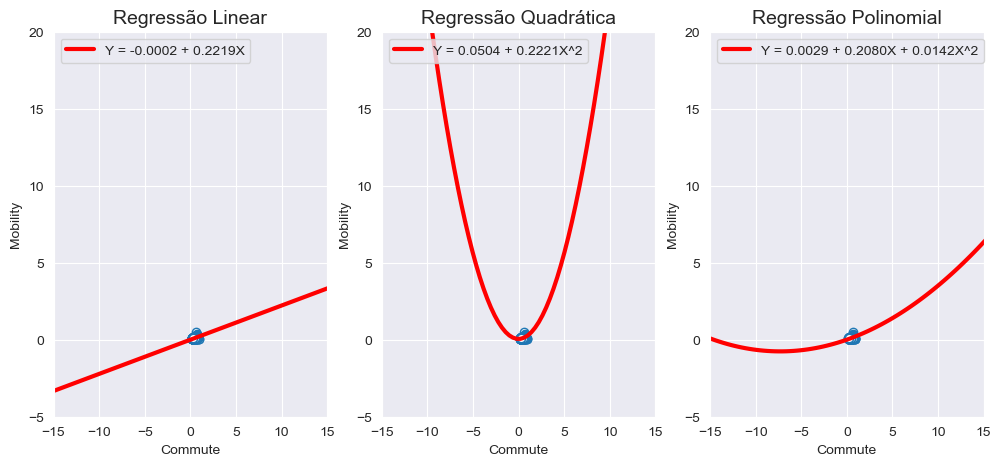

In [70]:
questao_4(df_mobility, params_mobility_linear, params_mobility_quadratic, params_mobility_polynomial, plot_domain = True)

## b)

É evidente, pelas matrizes de correlação abaixo, que simplesmente fazer uma coluna igual ao quadrado de outra redunda em alta correlação dos dados, com 0.986 de correlação entre a variável Commute e a variável Commute^2.

Realizando a centralização Z = X - X_média, o valor de correlação entre Z e Z^2 fica somente em 0.368, situação bem amis favorável - uma vez que colunas altamente correlacionadas, quase linearmente dependentes, resultam em matrizes não inversíveis, o que pode difcultar o cálculo do vetor parâmetro estimado.

Em relação aos erros do modelo, nenhum efeito foi notado com a centralização da variável - será observada a diferença no próximo exercício. 

In [71]:
df_mobility_clean = df_mobility[['Commute', 'Mobility', 'Region']].copy()
df_mobility_clean['Commute^2'] = df_mobility['Commute']**2
df_mobility_clean[['Commute','Commute^2', 'Mobility']].corr()

,Commute,Commute^2,Mobility
Commute,1.000000,0.985774,0.590634
Commute^2,0.985774,1.000000,0.583288
Mobility,0.590634,0.583288,1.000000


In [72]:
df_mobility_clean['Z'] = df_mobility_clean['Commute'] - df_mobility_clean['Commute'].mean()
df_mobility_clean['Z_quad'] = df_mobility_clean['Z']**2
df_mobility_clean[['Commute','Commute^2', 'Z', 'Z_quad', 'Mobility']].corr()

,Commute,Commute^2,Z,Z_quad,Mobility
Commute,1.000000,0.985774,1.000000,0.367867,0.590634
Commute^2,0.985774,1.000000,0.985774,0.518922,0.583288
Z,1.000000,0.985774,1.000000,0.367867,0.590634
Z_quad,0.367867,0.518922,0.367867,1.000000,0.223120
Mobility,0.590634,0.583288,0.590634,0.223120,1.000000


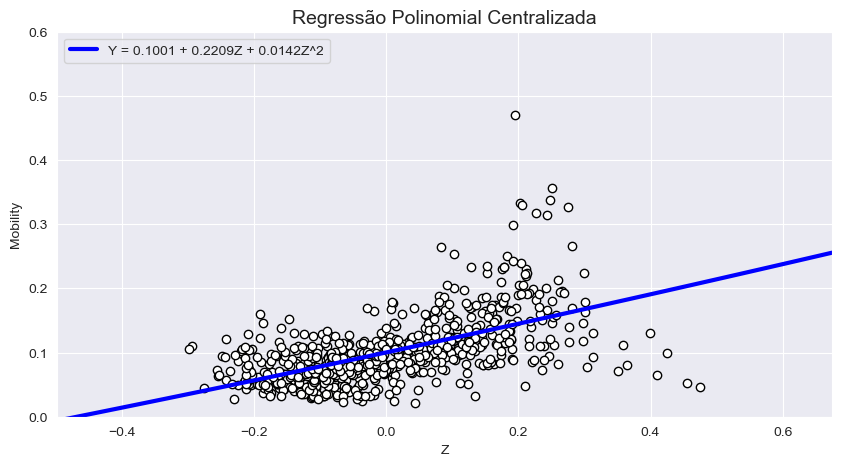

Estatísticas Resumidas - Modelo Polinomial - Normalizado:
MS - Regressão:		  0.352
MS - Resíduos:		   0.002
R²:					   0.349


In [73]:
model_mobility_polynomial_Z = smf.ols(formula='Mobility ~ Z + I(Z**2)', data=df_mobility_clean).fit()

questao_4Z(df_mobility_clean, model_mobility_polynomial_Z)

## c)

Observando os valores estimados dos coeficientes, fica claro que a centralização dos dados foi muito eficiente, principalmente por reduzir significativamente a erro padrão dos estimadores dos coeficientes. 

In [74]:
print("Modelo polinomial")
model_mobility_polynomial.params, model_mobility_polynomial.bse

Modelo polinomial


(Intercept          0.002876
 Commute            0.208020
 I(Commute ** 2)    0.014239
 dtype: float64,
 Intercept          0.015583
 Commute            0.066933
 I(Commute ** 2)    0.067837
 dtype: float64)

In [75]:
print("Modelo polinomial 'normalizado'")
model_mobility_polynomial_Z.params, model_mobility_polynomial_Z.bse

Modelo polinomial 'normalizado'


(Intercept    0.100144
 Z            0.220935
 I(Z ** 2)    0.014239
 dtype: float64,
 Intercept    0.002063
 Z            0.012098
 I(Z ** 2)    0.067837
 dtype: float64)

## d)

Observando os erros obtidos do model que faz a separação entre as regiões, fica evidente que essa mudança foi positiva, com redução do erro da regressão, mantendo o AIC e BIC bastante similar com os demais casos já apresentados.

Portanto, conclui-se que a mudança é desejável, e o modelo com separação por regiões é a melhor opção para explicar a mobilidade social, no presente caso.

In [76]:
model_mobility_polynomial_region = smf.ols(formula='Mobility ~ Commute*C(Region) + I(Commute**2)*C(Region)', data=df_mobility).fit()
print(model_mobility_polynomial_region.summary())

                            OLS Regression Results                            
Dep. Variable:               Mobility   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     93.02
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.34e-75
Time:                        22:52:02   Log-Likelihood:                 1293.3
No. Observations:                 729   AIC:                            -2575.
Df Residuals:                     723   BIC:                            -2547.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

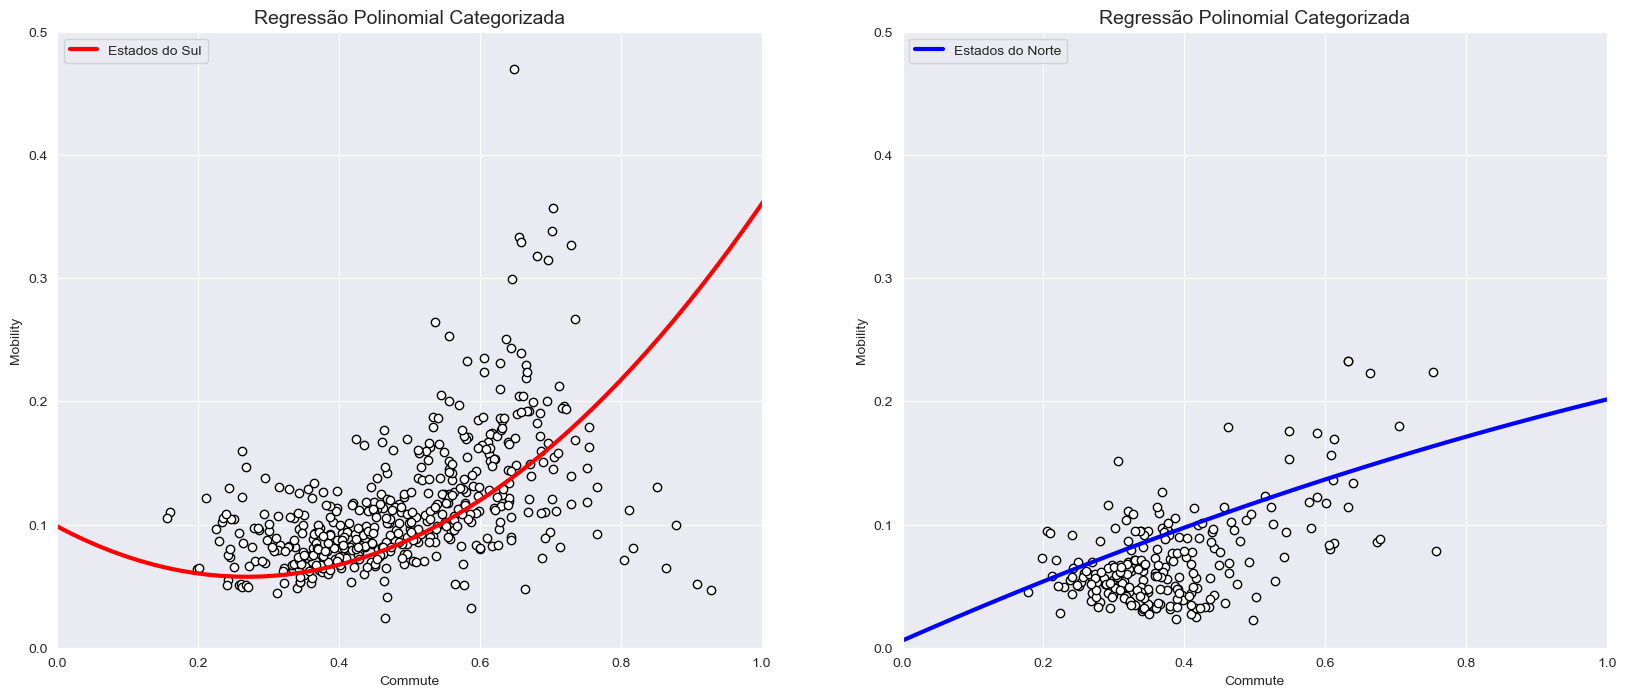

In [77]:
questao_4region(df_mobility, model_mobility_polynomial_region)

In [78]:
print("Modelo polinomial 'normalizado'")

print(f"Estatísticas Resumidas:\nMSR - Regressão:\t{model_mobility_polynomial_region.mse_model:7.3f}\nMSE - Resíduos:\t\t{model_mobility_polynomial_region.mse_resid:8.3f}\nR²:\t\t\t\t\t{model_mobility_polynomial_region.rsquared:8.3f}\n")
    
model_mobility_polynomial_region.params, model_mobility_polynomial_region.bse

Modelo polinomial 'normalizado'
Estatísticas Resumidas:
MSR - Regressão:	  0.158
MSE - Resíduos:		   0.002
R²:					   0.391


(Intercept                         0.005850
 C(Region)[T.1]                    0.092686
 Commute                           0.251220
 Commute:C(Region)[T.1]           -0.555779
 I(Commute ** 2)                  -0.055516
 I(Commute ** 2):C(Region)[T.1]    0.621618
 dtype: float64,
 Intercept                         0.019071
 C(Region)[T.1]                    0.036222
 Commute                           0.077874
 Commute:C(Region)[T.1]            0.165886
 I(Commute ** 2)                   0.076192
 I(Commute ** 2):C(Region)[T.1]    0.180767
 dtype: float64)